## API Spark DataFrame / Spark SQL

In [1]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
from pyspark.sql.types import StringType
import cartopy.crs as crs
from pyspark.sql import functions as F
from pyspark.sql.functions import col, count, desc, udf
import re
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.getOrCreate()

In [3]:
spark

Load all datasets

In [4]:
airports_usa = spark.read.csv("./airports-usa.csv", inferSchema=True, header=True)
countries = spark.read.csv("./countries-of-the-world.csv", inferSchema=True, header=True)

In [5]:
airports_usa.toPandas().head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [6]:
countries.toPandas().head()

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",None,None,None
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",None,None,None


### 1. Plotting Birthrate and Deathrate vs. GDP per Capita

visualize the relationship between Birthrate and Deathrate in relation to GDP per capita for the 30 richest and 30 poorest countries. 


In [7]:
countries.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- Population: integer (nullable = true)
 |-- Area (sq. mi.): integer (nullable = true)
 |-- Pop. Density (per sq. mi.): string (nullable = true)
 |-- Coastline (coast/area ratio): string (nullable = true)
 |-- Net migration: string (nullable = true)
 |-- Infant mortality (per 1000 births): string (nullable = true)
 |-- GDP ($ per capita): integer (nullable = true)
 |-- Literacy (%): string (nullable = true)
 |-- Phones (per 1000): string (nullable = true)
 |-- Arable (%): string (nullable = true)
 |-- Crops (%): string (nullable = true)
 |-- Other (%): string (nullable = true)
 |-- Climate: string (nullable = true)
 |-- Birthrate: string (nullable = true)
 |-- Deathrate: string (nullable = true)
 |-- Agriculture: string (nullable = true)
 |-- Industry: string (nullable = true)
 |-- Service: string (nullable = true)



In [8]:
# Filter the top 30 richest and bottom 30 poorest countries based on GDP per capita
countries_decs_by_gdp = countries.select("Birthrate", "Deathrate","GDP ($ per capita)").na.drop().orderBy(countries["GDP ($ per capita)"].desc())
top_30_richest_countries = countries_decs_by_gdp.head(30)
bottom_30_porest_countries = countries_decs_by_gdp.tail(30)
print(top_30_richest_countries) # top 30
print(bottom_30_porest_countries) # bottom 30

[Row(Birthrate='11,94', Deathrate='8,41', GDP ($ per capita)=55100), Row(Birthrate='11,46', Deathrate='9,4', GDP ($ per capita)=37800), Row(Birthrate='14,14', Deathrate='8,26', GDP ($ per capita)=37800), Row(Birthrate='11,4', Deathrate='7,74', GDP ($ per capita)=36000), Row(Birthrate='12,74', Deathrate='4,89', GDP ($ per capita)=35000), Row(Birthrate='10,02', Deathrate='8,17', GDP ($ per capita)=34600), Row(Birthrate='9,71', Deathrate='8,49', GDP ($ per capita)=32700), Row(Birthrate='11,13', Deathrate='10,36', GDP ($ per capita)=31100), Row(Birthrate='13,64', Deathrate='6,72', GDP ($ per capita)=30900), Row(Birthrate='8,74', Deathrate='9,76', GDP ($ per capita)=30000), Row(Birthrate='10,78', Deathrate='7,8', GDP ($ per capita)=29800), Row(Birthrate='14,45', Deathrate='7,82', GDP ($ per capita)=29600), Row(Birthrate='10,38', Deathrate='10,27', GDP ($ per capita)=29100), Row(Birthrate='12,14', Deathrate='7,51', GDP ($ per capita)=29000), Row(Birthrate='7,29', Deathrate='6,29', GDP ($ per

In [9]:
df = spark.createDataFrame(top_30_richest_countries + bottom_30_porest_countries)


In [10]:
df.printSchema() # DF birthare and deathrate are string

root
 |-- Birthrate: string (nullable = true)
 |-- Deathrate: string (nullable = true)
 |-- GDP ($ per capita): long (nullable = true)



<Axes: xlabel='Birthrate', ylabel='Deathrate'>

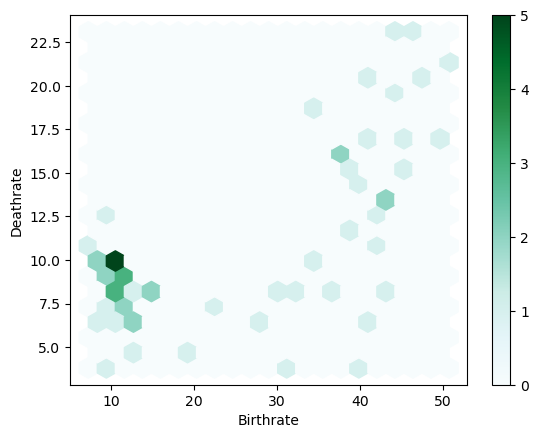

In [11]:

# Convert the PySpark DataFrame to a Pandas DataFrame
df_pandas = df.toPandas()

df_pandas['Birthrate'] = df_pandas['Birthrate'].str.replace(',', '.', regex=False) # replacing ',' with '.' otherwise after to_numeric data is NaN
df_pandas['Deathrate'] = df_pandas['Deathrate'].str.replace(',', '.', regex=False)

df_pandas['Birthrate'] = pd.to_numeric(df_pandas['Birthrate'], errors='coerce')
df_pandas['Deathrate'] = pd.to_numeric(df_pandas['Deathrate'], errors='coerce')
df_pandas.head(10)
# # Plot the hexbin
df_pandas.plot(kind="hexbin", x="Birthrate", y="Deathrate",gridsize=20)

### 2,3. Airports - top 10 higest lowest airport countries

In [12]:
airports = spark.read.csv("./airports.csv", inferSchema=True)

Add columns to airport dataframe

In [13]:
columns = [
    "id", "name", "city", "country", "iata", "icao", 
    "latitude", "longitude", "altitude", "timezone", 
    "dst", "tz", "type", "source"
]

In [14]:
airports =  airports.toDF(*columns)

In [15]:
airports.printSchema()

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- city: string (nullable = true)
 |-- country: string (nullable = true)
 |-- iata: string (nullable = true)
 |-- icao: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- altitude: integer (nullable = true)
 |-- timezone: string (nullable = true)
 |-- dst: string (nullable = true)
 |-- tz: string (nullable = true)
 |-- type: string (nullable = true)
 |-- source: string (nullable = true)



In [16]:
airports.toPandas().head()

,id,name,city,country,iata,icao,latitude,longitude,altitude,timezone,dst,tz,type,source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


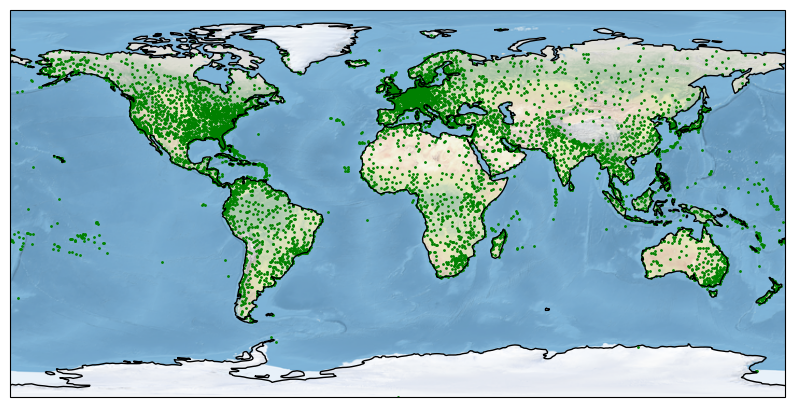

In [17]:
df = airports.select("Latitude","Longitude").toPandas()

plt.figure(figsize=[10, 10])
ax = plt.axes(projection=crs.PlateCarree())
ax.stock_img()
ax.coastlines()

lats = df["Latitude"].tolist()
longs = df["Longitude"].tolist()

plt.scatter(
    x=longs,
    y=lats,
    s=1,
    color="g",
    transform=crs.PlateCarree()
)
 
plt.show()

In [18]:
# Group by country and and aggregate by min(altitude)
lowest_airports_by_country = airports.groupBy("country") \
    .agg({"altitude": "min"}) \
    .withColumnRenamed("min(altitude)", "min_altitude_in_feets")

# Convert altitude from feet to meters, round to 2 decimal places
lowest_airports_by_country = lowest_airports_by_country.withColumn("min_altitude_in_meters", F.round(lowest_airports_by_country["min_altitude_in_feets"] * 0.3048, 2))

top_10_countries_with_highest_lowest_airport = lowest_airports_by_country \
    .orderBy(lowest_airports_by_country["min_altitude_in_meters"].desc()) \
    .limit(10)

top_10_countries_with_highest_lowest_airport.show()

+-----------+---------------------+----------------------+
|    country|min_altitude_in_feets|min_altitude_in_meters|
+-----------+---------------------+----------------------+
|    Lesotho|                 5105|                1556.0|
|     Rwanda|                 4859|               1481.02|
|    Burundi|                 2582|                786.99|
|  West Bank|                 2485|                757.43|
|     Uganda|                 2472|                753.47|
|  Swaziland|                 2075|                632.46|
| Kyrgyzstan|                 2058|                627.28|
|   Botswana|                 1772|                540.11|
|     Malawi|                 1580|                481.58|
|South Sudan|                 1513|                461.16|
+-----------+---------------------+----------------------+



### Plot number of airports vs country area

In [19]:
def normalize_country_name(s: str) -> str:
    s = s.replace("&", "and") \
        .replace(", The", "") \
        .replace("Rep.", "Republic") \
        .replace("Korea, North", "North Korea") \
        .replace("Korea, South", "South Korea") \
        .replace("Is.", "Island") \
        .replace("Islands", "Island")
    
    s = re.sub("Is(\s+|$)", "Island", s)
    s = re.sub("Congo.*", "Congo", s)
    s = re.sub("Micronesia.*", "Micronesia", s)
    
    return s.strip()

normalize_country_name_udf = udf(
    lambda s: normalize_country_name(s),
    StringType()
)

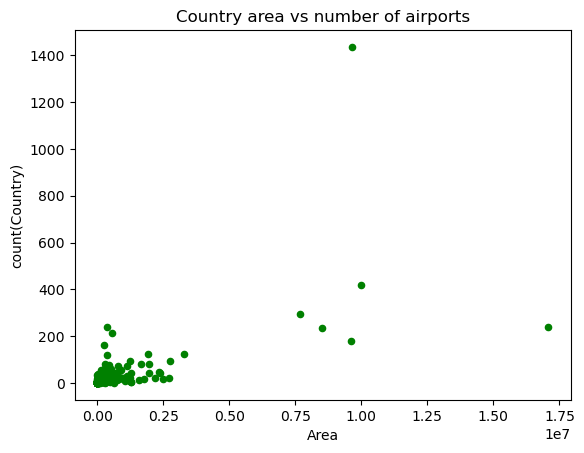

In [20]:
df_countries = (
    countries
    .withColumnRenamed("Area (sq. mi.)", "Area")
    .select("Country", "Area")
    .withColumn("Country", normalize_country_name_udf("Country"))
)

df_airports = (
    airports
    .select("Country")
    .withColumn("Country", normalize_country_name_udf("Country"))
)

df = (
    df_countries
    .join(df_airports, on="Country", how="left")
    .groupBy("Country", "Area")
    .agg(count("Country"))
    .drop("Country")
    .orderBy("Area")
)

ax = df.toPandas().plot.scatter(
    x="Area",
    y="count(Country)",
    color="green"
)
ax.set_title("Country area vs number of airports")
plt.show()

### Plot number of airports per continent

In [21]:
def region_to_continent(s: str) -> str:
    continents_map = {
        "ASIA": "Asia",
        "AFRICA": "Africa",
        "BALTICS": "Europe",
        "EUROPE": "Europe",
        "IND. STATES": "Asia",
        "LATIN AMER": "South America",
        "NEAR EAST": "Africa",
        "NORTHERN AMERICA": "North America",
    }
    
    for key, val in continents_map.items():
        if key in s:
            return val
    
    return "Other"

region_to_continent_udf = udf(
    lambda s: region_to_continent(s),
    StringType()
)

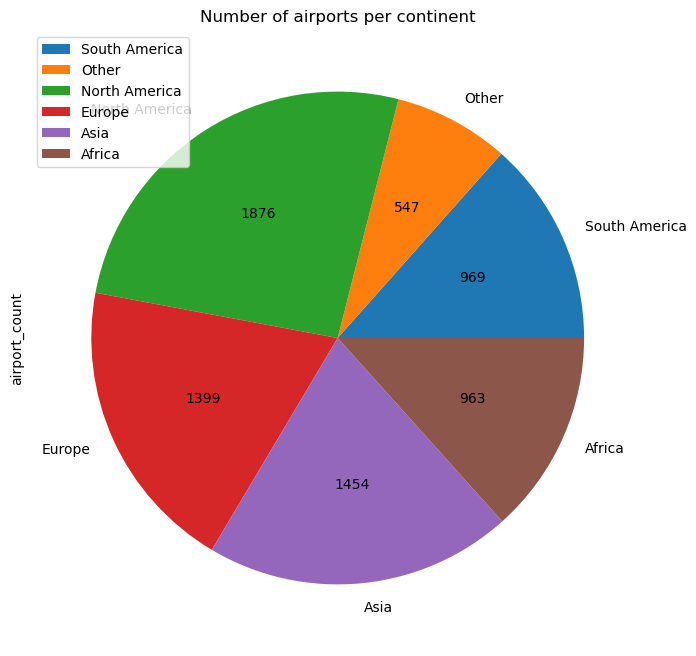

In [22]:
df_countries = (
    countries
    .select("Country", "Region")
    .withColumn("Country", normalize_country_name_udf("Country"))
    .withColumn("Continent", region_to_continent_udf("Region"))
    .drop("Region")
)

df_airports = (
    airports
    .select("Country")
    .withColumn("Country", normalize_country_name_udf("Country"))
)


df = (
    df_countries
    .join(df_airports, on="Country", how="left")
    .drop("Country")
    .groupBy("Continent")
    .agg(count("Continent").alias("airport_count"))
    .orderBy(desc("Continent"))
)

df_pandas = df.toPandas()

ax = df_pandas.plot.pie(
    y="airport_count",
    labels=df_pandas["Continent"],
    autopct=lambda p: '{:.0f}'.format(p * df_pandas['airport_count'].sum() / 100),
    title="Number of airports per continent",
    figsize=(8, 8)
)

plt.show()